### Importar librerias

In [2]:
from statsbombpy import sb
import mplsoccer as mpl
from mplsoccer import Pitch
from kloppy import metrica
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import ast
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import tensorflow_datasets as tfds
import shap
from lime.lime_tabular import LimeTabularExplainer

In [3]:
def bulid_cmap(x, y):
    r,g,b = x
    r_, g_, b_ = y
    N = 256
    A = np.ones((N, 4))
    A[:, 0] = np.linspace(r, 1, N)
    A[:, 1] = np.linspace(g, 1, N)
    A[:, 2] = np.linspace(b, 1, N)
    cmp = ListedColormap(A)
    
    B = np.ones((N, 4))
    B[:, 0] = np.linspace(r_, 1, N)
    B[:, 1] = np.linspace(g_, 1, N)
    B[:, 2] = np.linspace(b_, 1, N)
    cmp_ = ListedColormap(B)
    
    newcolors = np.vstack((cmp(np.linspace(0, 1, 128)),
                            cmp_(np.linspace(1, 0, 128))))
    return ListedColormap(newcolors)

In [4]:
blue, red = (44,123,182), (215,25,28)
blue = [x/256 for x in blue]
red = [x/256 for x in red]
diverging = bulid_cmap(blue, red)
diverging_r = bulid_cmap(red, blue)

In [5]:
matches = sb.matches(competition_id=43, season_id=106)
matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3857256,2022-12-02,21:00:00.000,International - FIFA World Cup,2022,Serbia,Switzerland,2,3,available,...,2023-04-26T23:49:58.956186,3,Group Stage,Stadium 974,Fernando Andrés Rapallini,Dragan Stojković,Murat Yakin,1.1.0,2,2
1,3869151,2022-12-03,21:00:00.000,International - FIFA World Cup,2022,Argentina,Australia,2,1,available,...,2023-07-30T07:48:51.865595,4,Round of 16,Ahmad bin Ali Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Graham James Arnold,1.1.0,2,2
2,3857257,2022-11-30,17:00:00.000,International - FIFA World Cup,2022,Australia,Denmark,1,0,available,...,2023-06-20T11:04:37.638969,3,Group Stage,Al Janoub Stadium,Mustapha Ghorbal,Graham James Arnold,Kasper Hjulmand,1.1.0,2,2
3,3857258,2022-11-24,21:00:00.000,International - FIFA World Cup,2022,Brazil,Serbia,2,0,available,...,2023-07-11T14:56:31.096588,1,Group Stage,Lusail Stadium,Alireza Faghani,Telê Santana da Silva,Dragan Stojković,1.1.0,2,2
4,3857288,2022-11-26,12:00:00.000,International - FIFA World Cup,2022,Tunisia,Australia,0,1,available,...,2023-04-27T00:30:07.835815,2,Group Stage,Al Janoub Stadium,Daniel Siebert,Jalel Kadri,Graham James Arnold,1.1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,3857265,2022-11-22,18:00:00.000,International - FIFA World Cup,2022,Mexico,Poland,0,0,available,...,2023-04-27T00:49:30.005344,1,Group Stage,Stadium 974,Chris Beath,Gerardo Daniel Martino,Czesław Michniewicz,1.1.0,2,2
60,3857262,2022-12-02,17:00:00.000,International - FIFA World Cup,2022,South Korea,Portugal,2,1,available,...,2023-04-26T23:48:08.999798,3,Group Stage,Education City Stadium,Facundo Tello Figueroa,Paulo Jorge Gomes Bento,Fernando Manuel Fernandes da Costa Santos,1.1.0,2,2
61,3857261,2022-11-29,21:00:00.000,International - FIFA World Cup,2022,Wales,England,0,3,available,...,2023-04-27T00:02:44.241621,3,Group Stage,Ahmad bin Ali Stadium,Slavko Vinčić,Robert Page,Gareth Southgate,1.1.0,2,2
62,3857255,2022-12-01,21:00:00.000,International - FIFA World Cup,2022,Japan,Spain,2,1,available,...,2023-04-26T23:51:48.352990,3,Group Stage,Sheikh Khalifa International Stadium,Victor Miguel de Freitas Gomes,Hajime Moriyasu,Luis Enrique Martínez García,1.1.0,2,2


In [6]:
# todos los match IDs de los partidos de Argentina
match_ids = matches['match_id'].tolist()

all_events = []

# Poner todos los eventos en un solo dataframe
for match_id in match_ids:
    match_events = sb.events(match_id=match_id)
    all_events.append(match_events)

# Concatenar
events = pd.concat(all_events, ignore_index=True)
events

#Llevar a csv
events.to_csv('events.csv', index=False)

                   count
Pass               68515
Ball Receipt*      63715
Carry              53764
Pressure           16553
Ball Recovery       5821
Duel                4389
Clearance           2684
Block               2386
Dribble             1793
Goal Keeper         1790
Foul Committed      1775
Miscontrol          1755
Foul Won            1693
Shot                1494
Dispossessed        1431
Interception        1371
Dribbled Past       1036
Substitution         587
Injury Stoppage      403
Half Start           286
Half End             286
Tactical Shift       243
50/50                236
Referee Ball-Drop    162
Starting XI          128
Shield               104
Player Off            74
Player On             74
Bad Behaviour         44
Error                 28
Offside               26
Own Goal Against       3
Own Goal For           3


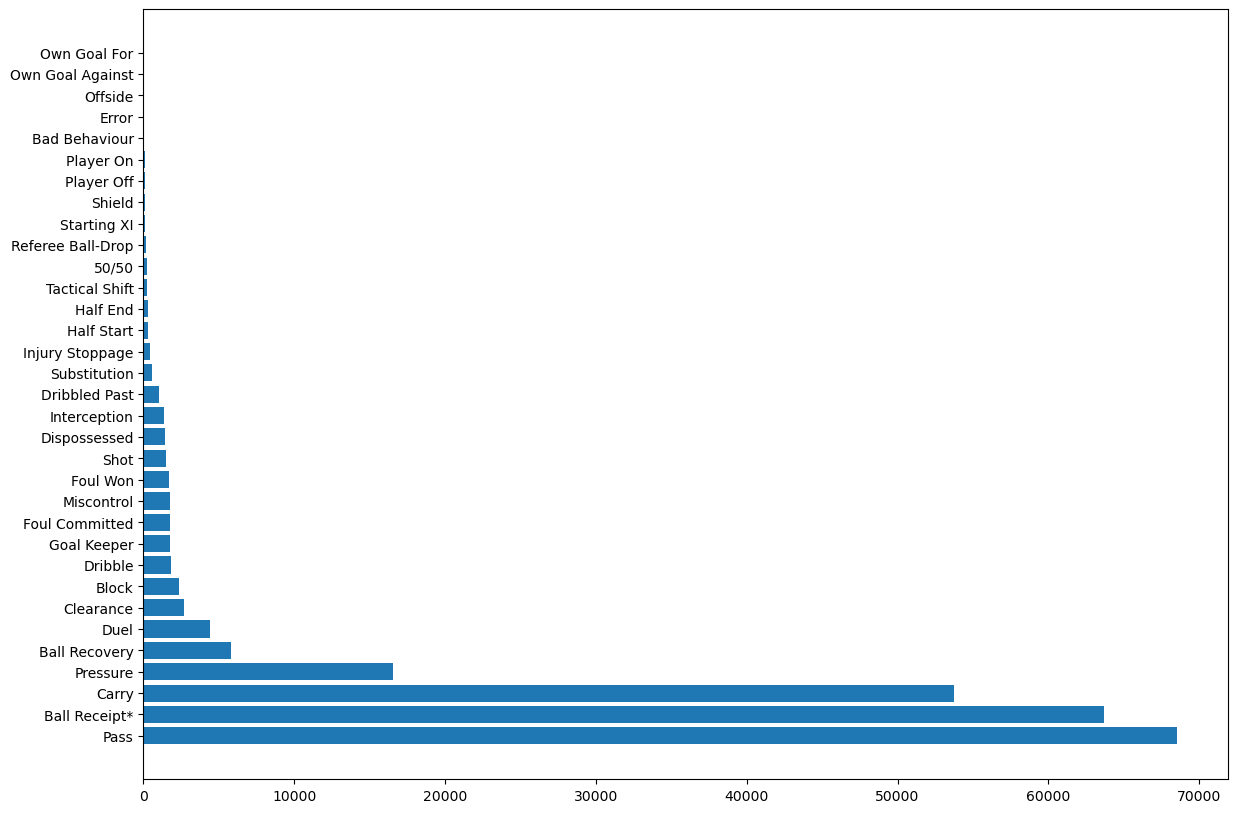

In [7]:
tipos_eventos = events['type'].unique().tolist()

#Crear un diccionario con la frecuencia de cada tipo de evento
frecuencia_eventos = events['type'].value_counts().to_dict()

# Crear un diccionario con la frecuencia de cada tipo de evento
frecuencia_eventos = events['type'].value_counts().to_dict()
# Convertir el diccionario a DataFrame para poder ordenarlo
frecuencia_df = pd.DataFrame.from_dict(frecuencia_eventos, orient='index', columns=['count'])
print(frecuencia_df.sort_values('count', ascending=False))
plt.figure(figsize=(14, 10))
plt.barh(frecuencia_df.index, frecuencia_df['count'])
plt.xticks(rotation=0)
plt.show()

In [8]:
# Crear dataframe con los eventos de tiro de los partidos de Argentina
lista_columnas = ['type', 
                  'shot_outcome', 
                  'shot_body_part', 
                  'shot_technique',
                  'location',
                  'team',
                  'player',
                  'timestamp',
                  'period']
df_tiros = events[events['type'] == 'Shot'][lista_columnas]
df_tiros

,type,shot_outcome,shot_body_part,shot_technique,location,team,player,timestamp,period
2674,Shot,Blocked,Left Foot,Half Volley,"[96.0, 38.8]",Switzerland,Granit Xhaka,00:00:18.696,1
2675,Shot,Saved,Left Foot,Half Volley,"[113.1, 40.7]",Switzerland,Breel-Donald Embolo,00:00:22.129,1
2676,Shot,Saved,Right Foot,Half Volley,"[103.8, 41.9]",Switzerland,Granit Xhaka,00:00:23.845,1
2677,Shot,Off T,Head,Normal,"[112.2, 36.8]",Serbia,Nikola Milenković,00:04:35.297,1
2678,Shot,Post,Left Foot,Normal,"[97.8, 51.5]",Serbia,Andrija Živković,00:10:05.636,1
...,...,...,...,...,...,...,...,...,...
234456,Shot,Post,Head,Normal,"[118.2, 43.9]",Denmark,Andreas Evald Cornelius,00:24:16.276,2
234457,Shot,Off T,Right Foot,Normal,"[102.5, 24.2]",Denmark,Mathias Jensen,00:30:27.456,2
234458,Shot,Saved,Head,Normal,"[114.4, 36.8]",Denmark,Andreas Evald Cornelius,00:46:09.522,2
234459,Shot,Blocked,Right Foot,Normal,"[95.0, 30.2]",Denmark,Joakim Mæhle,00:46:41.468,2


Text(0.5, 0, 'xG')

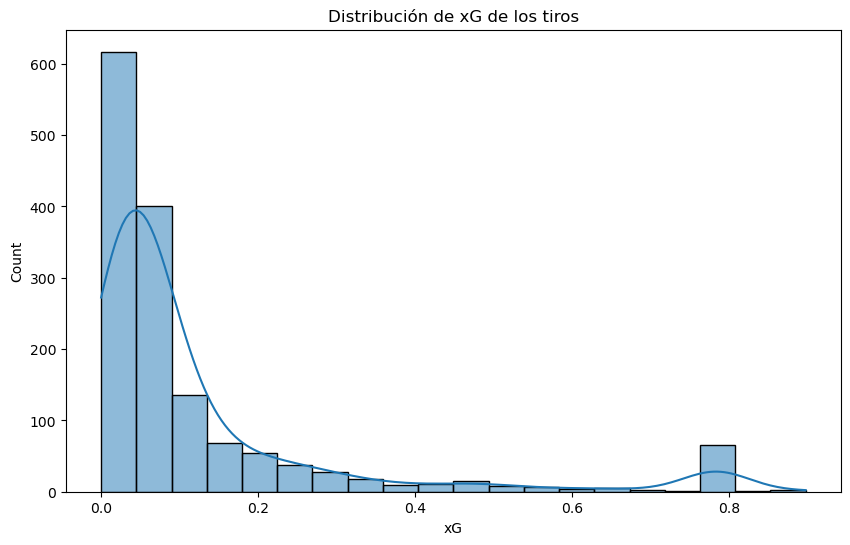

In [9]:
xG_statsbomb = events['shot_statsbomb_xg']
xG_statsbomb

#Crear un dataframe con los tiros y el xG
df_tiros_xG = pd.DataFrame({'shot_outcome': events['shot_outcome'], 'xG': events['shot_statsbomb_xg']})
df_tiros_xG

#Graficar el xG de los tiros
plt.figure(figsize=(10, 6))
sns.histplot(df_tiros_xG['xG'], bins=20, kde=True)
plt.title('Distribución de xG de los tiros')
plt.xlabel('xG')

In [10]:
#Coordenadas de los tiros de Argentina
coordinates = df_tiros['location']
coordinates

2674       [96.0, 38.8]
2675      [113.1, 40.7]
2676      [103.8, 41.9]
2677      [112.2, 36.8]
2678       [97.8, 51.5]
              ...      
234456    [118.2, 43.9]
234457    [102.5, 24.2]
234458    [114.4, 36.8]
234459     [95.0, 30.2]
234460    [108.8, 46.4]
Name: location, Length: 1494, dtype: object

### Dispersión de tiros vs. goles

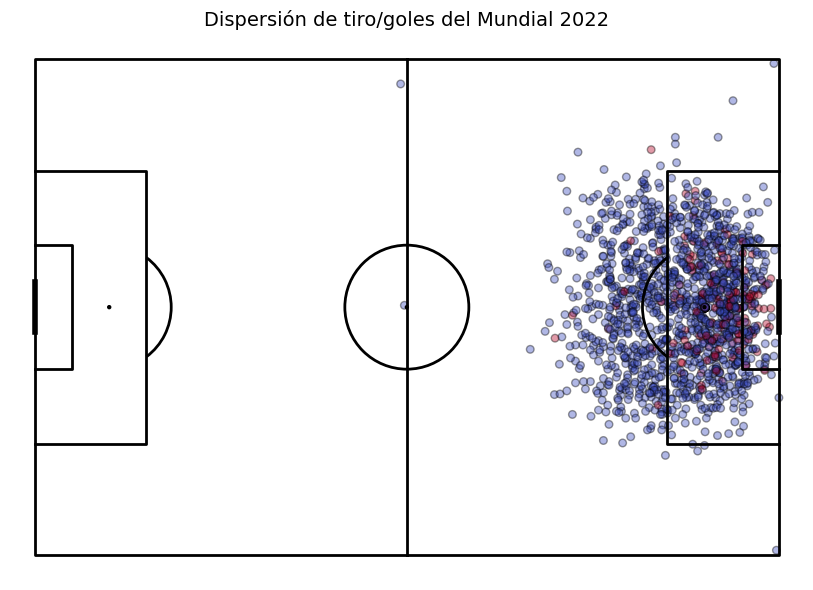

In [11]:
# Filtrar los tiros de Argentina
df_remates = df_tiros.copy()

# Coordenadas y color (1 = Gol, 0 = No Gol)
x = [loc[0] for loc in df_remates['location']]
y = [loc[1] for loc in df_remates['location']]
colores = df_remates['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Dibujar cancha
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 6))

# Dibujar los tiros
scatter = pitch.scatter(x, y, c=colores, cmap='coolwarm', edgecolors='black', alpha=0.4, s=30, ax=ax)

# Título
plt.title("Dispersión de tiro/goles del Mundial 2022", fontsize=14)
plt.show()


### Mapa de calor de los tiros

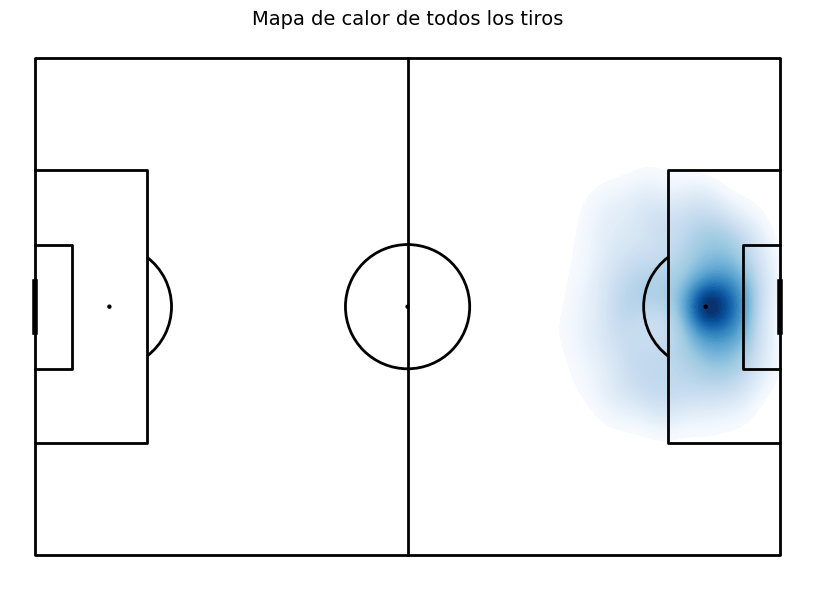

In [12]:
# Crear cancha
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 6))

# Dibujar el mapa de calor KDE sobre la cancha
pitch.kdeplot(x, y, ax=ax, cmap='Blues', fill=True, levels=100, alpha=1, edgecolors='black')

# Título
plt.title("Mapa de calor de todos los tiros", fontsize=14)
plt.show()


### Mapa de calor de los goles

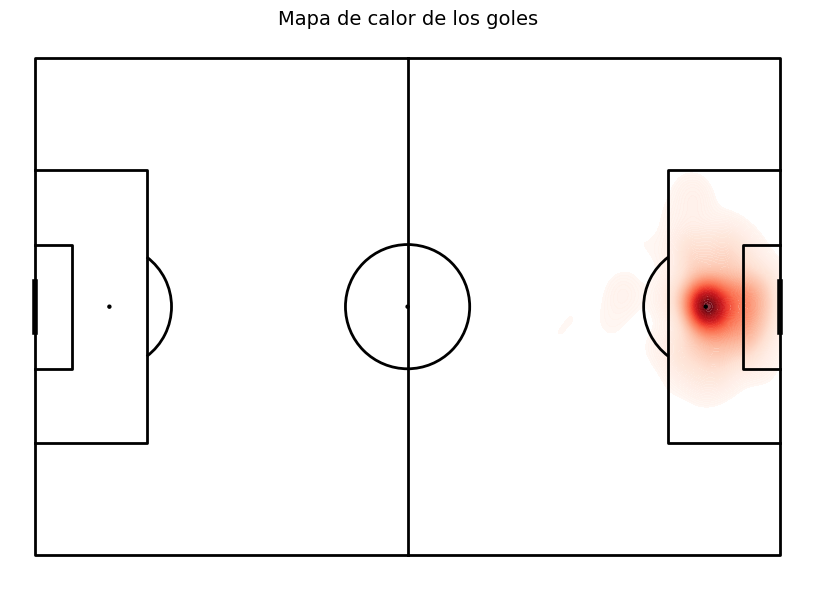

In [13]:
# Extraer coordenadas de goles de Argentina
df_goles = df_tiros[df_tiros['shot_outcome'] == 'Goal'].copy()
x = [loc[0] for loc in df_goles['location']]
y = [loc[1] for loc in df_goles['location']]

# Crear cancha
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 6))

# Dibujar el mapa de calor KDE sobre la cancha
pitch.kdeplot(x, y, ax=ax, cmap='Reds', fill=True, levels=100, alpha=0.8)

# Título
plt.title("Mapa de calor de los goles", fontsize=14)
plt.show()


In [14]:
#Test y training
# Convertir ubicacion a tipo string
X = df_tiros.drop(columns=['shot_outcome'])
X['location'] = X['location'].astype(str)  # Convert lists to strings
Y = df_tiros['shot_outcome']

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_processed = preprocessor.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y, test_size=0.2, random_state=42)

In [15]:
# Usar solo las columnas numéricas como en los otros modelos
X_train_numeric = X_train.toarray()[:, :1] # Tomamos solo la columna shot_statsbomb_xg que es numérica
X_test_numeric = X_test.toarray()[:, :1]

solvers = ['lbfgs', 'sgd', 'adam']
results = []

for solver in solvers:
    mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver=solver, max_iter=500, random_state=42)
    mlp.fit(X_train_numeric, Y_train)
    Y_pred = mlp.predict(X_test_numeric)
    accuracy = accuracy_score(Y_test, Y_pred)
    results.append({
        'solver': solver,
        'accuracy': accuracy
    })

results_df = pd.DataFrame(results)
print("\nResumen de resultados:")
print(results_df)


Resumen de resultados:
  solver  accuracy
0  lbfgs  0.280936
1    sgd  0.284281
2   adam  0.280936


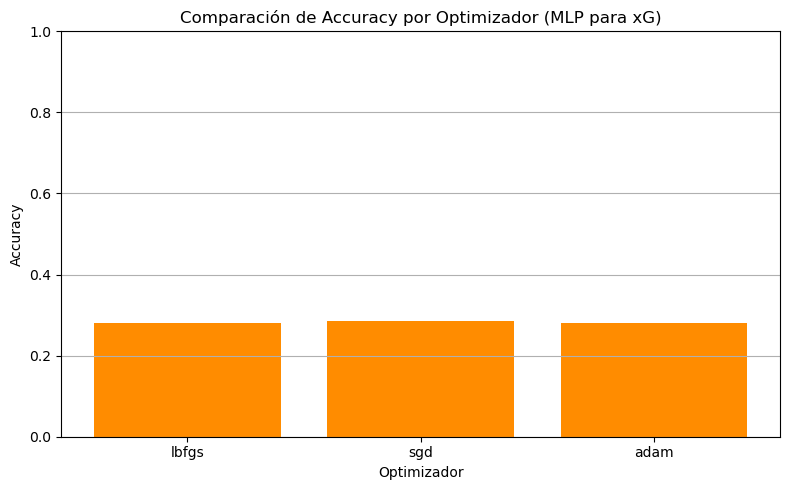

In [16]:
plt.figure(figsize=(8, 5))
plt.bar(results_df['solver'], results_df['accuracy'], color='darkorange')
plt.title("Comparación de Accuracy por Optimizador (MLP para xG)")
plt.xlabel("Optimizador")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [17]:
# Crear y entrenar el modelo de regresión logística con las variables de train y test de los bloques anteriores
model = LogisticRegression(random_state=42)
model.fit(X_train_numeric, Y_train)

# Realizar predicciones
Y_pred = model.predict(X_test_numeric)

# Calcular accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f"\nAccuracy del modelo de regresión logística: {accuracy:.4f}")



Accuracy del modelo de regresión logística: 0.2843


## 6. Evaluación del Modelo:

### Modelo MLPClassifier (Perceptrón Multicapa)

In [18]:
# Convertir matriz a array denso, si es necesario
X_train_numeric = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
X_test_numeric = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

# Configuración del modelo y estandarización de etiquetas
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                    solver='sgd', max_iter=500, random_state=42)

mlp.fit(X_train_numeric, Y_train_encoded)
y_pred_proba_2 = mlp.predict_proba(X_test_numeric)[:, 1]
y_pred_2 = (y_pred_proba_2 > 0.5).astype(int)

accuracy_2 = accuracy_score(Y_test_encoded, y_pred_2)
print(f"Accuracy: {accuracy_2}")

Accuracy: 0.3010033444816054


In [19]:
# Configuración del modelo y estandarización de etiquetas
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), 
                    activation='relu', 
                    solver='sgd', 
                    max_iter=500, 
                    random_state=42)

# Entrenamiento
mlp.fit(X_train_numeric, Y_train_encoded)

# Predicción
Y_pred_mlp = mlp.predict(X_test_numeric)

# Evaluación
print("Reporte de clasificación del MLP (0: No gol, 1: Gol):")
print(classification_report(Y_test_encoded, Y_pred_mlp, 
                          labels=np.unique(Y_test_encoded),
                          target_names=['No gol', 'Gol']))


Reporte de clasificación del MLP (0: No gol, 1: Gol):
              precision    recall  f1-score   support

      No gol       0.35      0.35      0.35        85
         Gol       0.31      0.14      0.19        36

    accuracy                           0.33       299
   macro avg       0.18      0.18      0.17       299
weighted avg       0.30      0.33      0.30       299



### Matriz de Confusión para el modelo MLP

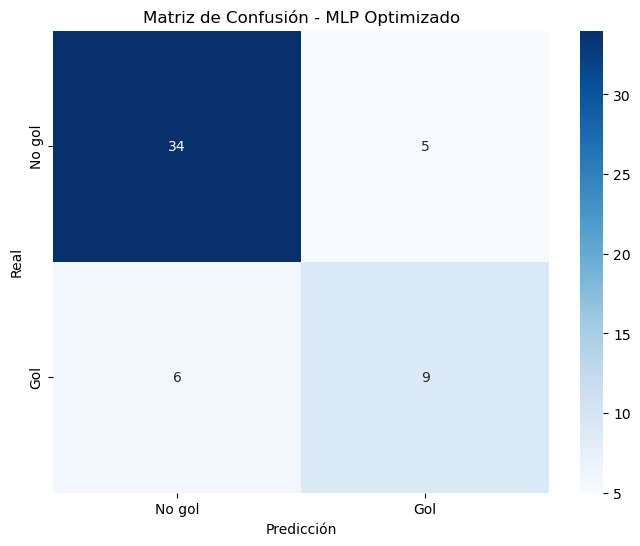


Mejores hiperparámetros encontrados:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 32, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}

Métricas de evaluación del modelo optimizado:
Accuracy: 0.324
Precision: 0.318
Recall: 0.324
F1-score: 0.319


In [20]:
# Ajustar hiperparámetros del modelo
param_grid = {
    'hidden_layer_sizes': [(64,32), (128,64)],  # Removed largest network
    'activation': ['relu'],
    'learning_rate_init': [0.001],  # Single learning rate
    'batch_size': [32],  # Single batch size
    'alpha': [0.0001]  # Single regularization parameter
}

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42),  # Reduced max iterations
    param_grid,
    cv=3,  # Reduced number of folds
    scoring='f1_weighted',
    n_jobs=2  # Limit parallel jobs
)

# Entrenar el modelo con los mejores hiperparámetros
grid_search.fit(X_train_numeric, Y_train_encoded)
best_mlp = grid_search.best_estimator_

# Obtener predicciones con el mejor modelo
y_pred_mlp = best_mlp.predict(X_test_numeric)

# Crear y visualizar matriz de confusión
conf_matrix = confusion_matrix(Y_test_encoded, y_pred_mlp, labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No gol', 'Gol'],
            yticklabels=['No gol', 'Gol'])
plt.title('Matriz de Confusión - MLP Optimizado')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Imprimir métricas del modelo optimizado
print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("\nMétricas de evaluación del modelo optimizado:")
print(f"Accuracy: {accuracy_score(Y_test_encoded, y_pred_mlp):.3f}")
print(f"Precision: {precision_score(Y_test_encoded, y_pred_mlp, average='weighted'):.3f}")
print(f"Recall: {recall_score(Y_test_encoded, y_pred_mlp, average='weighted'):.3f}")
print(f"F1-score: {f1_score(Y_test_encoded, y_pred_mlp, average='weighted'):.3f}")


### Curva de pérdida del modelo MLP

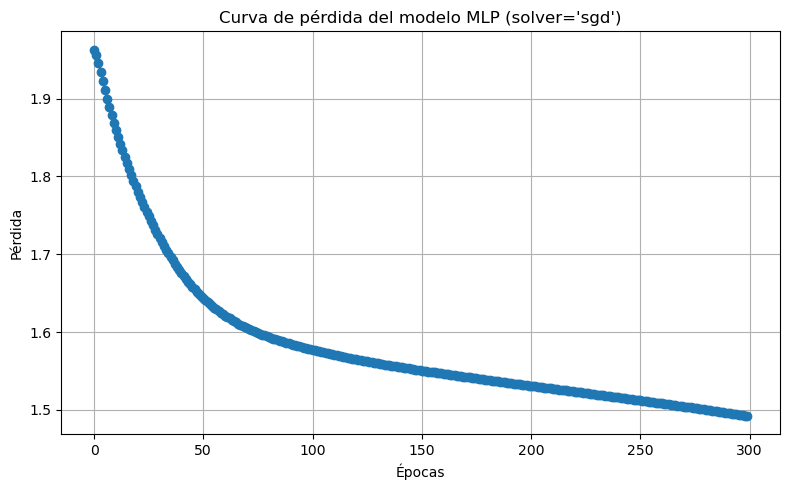

In [21]:
#Curva de pérdida del modelo MLP
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    activation='relu',
                    solver='sgd', 
                    learning_rate_init=0.001,
                    max_iter=300,
                    random_state=42)

mlp.fit(X_train_numeric, Y_train_encoded)

plt.figure(figsize=(8, 5))
plt.plot(mlp.loss_curve_, marker='o')
plt.title("Curva de pérdida del modelo MLP (solver='sgd')")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.grid(True)
plt.tight_layout()
plt.show()

## Practica 2

# Prueba con tensorflow

In [22]:
X_train_tensor = tf.convert_to_tensor(X_train_numeric)
Y_train_tensor = tf.convert_to_tensor(Y_train_encoded)

# Modelo más profundo
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Clasificación binaria (es gol o no)
])

In [23]:
# Compilar
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Entrenar
history = model.fit(X_train_tensor, Y_train_tensor, validation_split=0.2, epochs=50,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                    batch_size=16, verbose=1)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1287 - loss: -5.5450 - val_accuracy: 0.1548 - val_loss: -2.2971
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1276 - loss: -61.7789 - val_accuracy: 0.1548 - val_loss: -33.9112
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1276 - loss: -662.8742 - val_accuracy: 0.1548 - val_loss: -334.0718
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1276 - loss: -4954.4316 - val_accuracy: 0.1548 - val_loss: -1900.4995
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1276 - loss: -22048.6348 - val_accuracy: 0.1548 - val_loss: -8721.5332
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1276 - loss: -68420.2734 - val_accuracy: 0.1548 - val_loss: -30657.3906
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1276 - loss: -166684.7188 - val_accuracy: 0.1548 - val_loss: -67722.2031
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1276

## Práctica 3

In [25]:
# Convertir outcome a binario sin depender de nombres de categorías
df_tiros_goles = df_tiros.copy()
df_tiros_goles = df_tiros_goles[df_tiros_goles['shot_outcome'].notna()].copy()
df_tiros_goles['shot_outcome'] = (df_tiros_goles['shot_outcome'] == 'Goal').astype(int)
df_tiros_goles


,type,shot_outcome,shot_body_part,shot_technique,location,team,player,timestamp,period
2674,Shot,0,Left Foot,Half Volley,"[96.0, 38.8]",Switzerland,Granit Xhaka,00:00:18.696,1
2675,Shot,0,Left Foot,Half Volley,"[113.1, 40.7]",Switzerland,Breel-Donald Embolo,00:00:22.129,1
2676,Shot,0,Right Foot,Half Volley,"[103.8, 41.9]",Switzerland,Granit Xhaka,00:00:23.845,1
2677,Shot,0,Head,Normal,"[112.2, 36.8]",Serbia,Nikola Milenković,00:04:35.297,1
2678,Shot,0,Left Foot,Normal,"[97.8, 51.5]",Serbia,Andrija Živković,00:10:05.636,1
...,...,...,...,...,...,...,...,...,...
234456,Shot,0,Head,Normal,"[118.2, 43.9]",Denmark,Andreas Evald Cornelius,00:24:16.276,2
234457,Shot,0,Right Foot,Normal,"[102.5, 24.2]",Denmark,Mathias Jensen,00:30:27.456,2
234458,Shot,0,Head,Normal,"[114.4, 36.8]",Denmark,Andreas Evald Cornelius,00:46:09.522,2
234459,Shot,0,Right Foot,Normal,"[95.0, 30.2]",Denmark,Joakim Mæhle,00:46:41.468,2


In [26]:
# Extraer coordenadas y calcular variables

coords = df_tiros_goles['location'].dropna().apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_tiros_goles['x'] = coords.apply(lambda p: p[0] if isinstance(p, list) else None)
df_tiros_goles['y'] = coords.apply(lambda p: p[1] if isinstance(p, list) else None)

# Calculamos distancia y ángulo (marco StatsBomb: campo 120x80, arco centrado en y=40; ancho del arco ~7.32m)

df_tiros_goles['distance'] = np.sqrt((120 - df_tiros_goles['x'])**2 + (40 - df_tiros_goles['y'])**2)
df_tiros_goles['angle'] = np.arctan2(7.32 * (120 - df_tiros_goles['x']),
                         ((120 - df_tiros_goles['x'])**2 + (np.abs(df_tiros_goles['y'] - 40))**2 - (7.32 / 2)**2))


In [27]:
# Variables finales

df_model = df_tiros_goles[['distance', 'angle', 'shot_body_part', 'type', 'shot_outcome']].dropna()
X = df_model.drop(columns='shot_outcome')
y = df_model['shot_outcome']

# Preprocesamiento

num_cols = ['distance', 'angle']
cat_cols = ['shot_body_part', 'type']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

from scipy.sparse import issparse
X_train_arr = X_train_proc.toarray() if issparse(X_train_proc) else X_train_proc
X_test_arr = X_test_proc.toarray() if issparse(X_test_proc) else X_test_proc

# Convert to numpy arrays for Keras

X_train_np = np.array(X_train_arr)
X_test_np = np.array(X_test_arr)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

train_dataset = TensorDataset(torch.FloatTensor(X_train_np), torch.FloatTensor(y_train_np))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("Dimension datos de entrenamiento: ", X_train_np.shape)
print("Dimension datos de prueba: ", X_test_np.shape)


Dimension datos de entrenamiento:  (1120, 7)
Dimension datos de prueba:  (374, 7)


In [28]:
class DNNModel(nn.Module):
    def __init__(self, input_dim):
        super(DNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [29]:
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_proc)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model with correct input dimension
model = DNNModel(X_train_proc.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()


In [30]:
# Convertir datos de test a PyTorch tensors
X_test_tensor = torch.FloatTensor(X_test_proc)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Evaluar el modelo
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred = (y_pred_probs > 0.5).float()

accuracy = accuracy_score(y_test_tensor, y_pred)
precision = precision_score(y_test_tensor, y_pred)
recall = recall_score(y_test_tensor, y_pred)
f1 = f1_score(y_test_tensor, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.86
Precision: 0.33
Recall: 0.08
F1 Score: 0.13


In [31]:
#Entrenamiento

# Asegurar tipos tensores y dispositivos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# (X_train_tensor, y_train_tensor, train_loader, X_test_tensor, y_test_tensor)

if 'train_loader' not in globals():
    assert 'X_train_np' in globals() and 'y_train_np' in globals(), "Faltan X_train_np / y_train_np para recrear tensores."
    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np.reshape(-1, 1), dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

if 'X_test_tensor' not in globals() or 'y_test_tensor' not in globals():
    assert 'X_test_np' in globals() and 'y_test_np' in globals(), "Faltan X_test_np / y_test_np para recrear tensores."
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np.reshape(-1, 1), dtype=torch.float32)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Definición de pérdida y optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_acc_list, val_acc_list, loss_list = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_acc = correct / total if total > 0 else 0.0
    train_acc_list.append(train_acc)
    loss_list.append(running_loss / max(1, len(train_loader)))
    
    # Validación por época
    model.eval()
    with torch.no_grad():
        outputs_val = model(X_test_tensor)
        preds_val = (outputs_val > 0.5).float()
        val_acc = (preds_val == y_test_tensor).sum().item() / y_test_tensor.size(0)
        val_acc_list.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {loss_list[-1]:.4f}  "
          f"Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

Epoch [1/50]  Loss: 0.3251  Train Acc: 0.8750  Val Acc: 0.8503
Epoch [2/50]  Loss: 0.3071  Train Acc: 0.8696  Val Acc: 0.8503
Epoch [3/50]  Loss: 0.3112  Train Acc: 0.8759  Val Acc: 0.8610
Epoch [4/50]  Loss: 0.3111  Train Acc: 0.8732  Val Acc: 0.8476
Epoch [5/50]  Loss: 0.3020  Train Acc: 0.8732  Val Acc: 0.8556
Epoch [6/50]  Loss: 0.3138  Train Acc: 0.8804  Val Acc: 0.8556
Epoch [7/50]  Loss: 0.3096  Train Acc: 0.8723  Val Acc: 0.8556
Epoch [8/50]  Loss: 0.3056  Train Acc: 0.8768  Val Acc: 0.8556
Epoch [9/50]  Loss: 0.3098  Train Acc: 0.8795  Val Acc: 0.8503
Epoch [10/50]  Loss: 0.3103  Train Acc: 0.8768  Val Acc: 0.8556
Epoch [11/50]  Loss: 0.3077  Train Acc: 0.8786  Val Acc: 0.8663
Epoch [12/50]  Loss: 0.3103  Train Acc: 0.8750  Val Acc: 0.8529
Epoch [13/50]  Loss: 0.3087  Train Acc: 0.8741  Val Acc: 0.8503
Epoch [14/50]  Loss: 0.3071  Train Acc: 0.8768  Val Acc: 0.8636
Epoch [15/50]  Loss: 0.3089  Train Acc: 0.8804  Val Acc: 0.8610
Epoch [16/50]  Loss: 0.3064  Train Acc: 0.8795  V

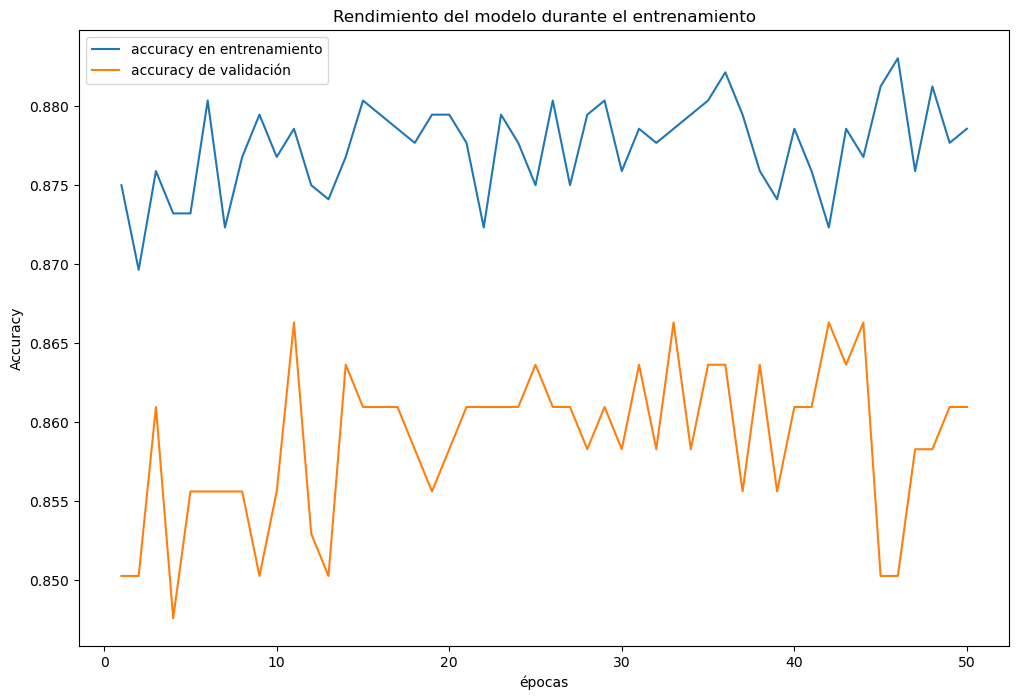

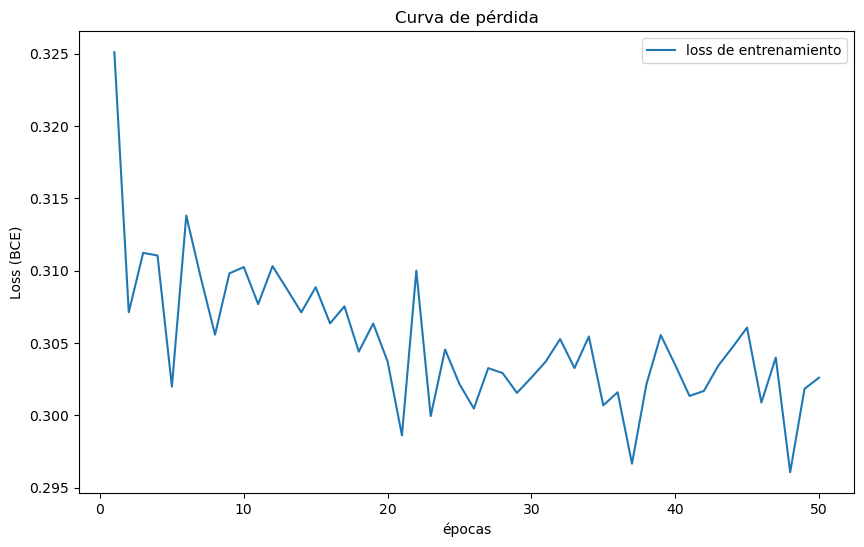

In [32]:
# Graficar accuracies
plt.figure(figsize=(12,8))
plt.plot(range(1, num_epochs+1), train_acc_list, label="accuracy en entrenamiento")
plt.plot(range(1, num_epochs+1), val_acc_list, label="accuracy de validación")
plt.xlabel("épocas")
plt.ylabel("Accuracy")
plt.title("Rendimiento del modelo durante el entrenamiento")
plt.legend()
plt.show()

# Graficar pérdida
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), loss_list, label="loss de entrenamiento")
plt.xlabel("épocas")
plt.ylabel("Loss (BCE)")
plt.title("Curva de pérdida")
plt.legend()
plt.show()

## Modelo con *Transfer Learning Tabular*: CatBoost + SHAP

CatBoost — Accuracy: 0.749  Precision: 0.317  Recall: 0.796  F1: 0.453


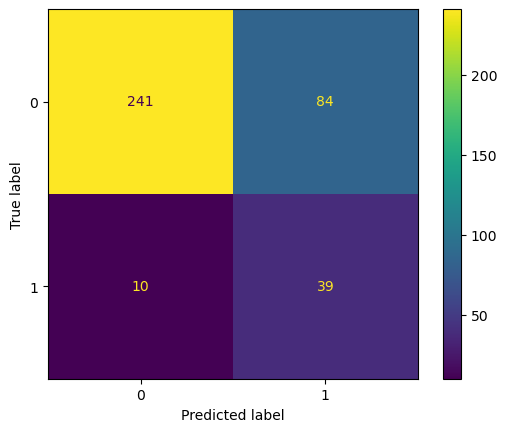

In [33]:
# Instalación/Importación robusta de CatBoost y SHAP
try:
    from catboost import CatBoostClassifier, Pool # type: ignore
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "catboost", "shap"])
    from catboost import CatBoostClassifier, Pool # type: ignore

# Asegurar que existen X, y, X_train, X_test, y_train, y_test y las columnas categóricas
assert 'X' in globals() and 'y' in globals(), "No se encontró X/y. Ejecuta las celdas previas (definición de df_model, X, y)."
assert 'X_train' in globals() and 'X_test' in globals(), "No se encontró el split de train/test. Ejecuta las celdas previas."
assert 'y_train' in globals() and 'y_test' in globals(), "No se encontró y_train/y_test. Ejecuta las celdas previas."

# Columnas categóricas tal como se definieron antes
cat_cols = ['shot_body_part', 'type']
num_cols = ['distance', 'angle']

# Índices de columnas categóricas en X (para CatBoost)
cat_features_idx = [X.columns.get_loc(c) for c in cat_cols if c in X.columns]

# Pool de CatBoost (maneja categóricas sin One-Hot)
train_pool = Pool(X_train, label=y_train, cat_features=cat_features_idx)
test_pool  = Pool(X_test,  label=y_test,  cat_features=cat_features_idx)

# Pesos de clase para mitigar desbalance (w1 = n_neg/n_pos, w0=1)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
class_weights = [1.0, float(neg/pos)] if pos > 0 else [1.0, 1.0]

# Modelo CatBoost (transfer learning tabular)
cat_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="F1",
    depth=6,
    learning_rate=0.05,
    iterations=800,
    l2_leaf_reg=3.0,
    class_weights=class_weights,
    random_state=42,
    verbose=False
)

cat_model.fit(train_pool, eval_set=test_pool, verbose=False)

# Predicciones
y_proba_cat = cat_model.predict_proba(test_pool)[:, 1]
y_pred_cat = (y_proba_cat >= 0.5).astype(int)

# Métricas
acc_cat = accuracy_score(y_test, y_pred_cat)
prec_cat = precision_score(y_test, y_pred_cat, zero_division=0)
rec_cat = recall_score(y_test, y_pred_cat, zero_division=0)
f1_cat = f1_score(y_test, y_pred_cat, zero_division=0)

print(f"CatBoost — Accuracy: {acc_cat:.3f}  Precision: {prec_cat:.3f}  Recall: {rec_cat:.3f}  F1: {f1_cat:.3f}")

# Matriz de confusión CatBoost
cm_cat = confusion_matrix(y_test, y_pred_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cat, display_labels=[0,1])
_ = disp.plot(values_format='d')


In [34]:
# Recolectar metricas del DNN y compararlas con CatBoost

dnn_metrics = {}
if 'y_pred' in globals() and 'y_test_tensor' in globals():
    # y_pred es tensor float; lo convertimos a numpy int
    y_pred_dnn = y_pred.cpu().numpy().astype(int) if hasattr(y_pred, 'cpu') else np.array(y_pred).astype(int)
    y_true_dnn = y_test_tensor.cpu().numpy().astype(int) if hasattr(y_test_tensor, 'cpu') else np.array(y_test_tensor).astype(int)
    dnn_metrics = {
        "Accuracy": float(accuracy_score(y_true_dnn, y_pred_dnn)),
        "Precision": float(precision_score(y_true_dnn, y_pred_dnn, zero_division=0)),
        "Recall": float(recall_score(y_true_dnn, y_pred_dnn, zero_division=0)),
        "F1": float(f1_score(y_true_dnn, y_pred_dnn, zero_division=0)),
    }
else:
    # fallback: volver a evaluar el DNN si existe 'model' y 'X_test_tensor'
    if 'model' in globals() and 'X_test_tensor' in globals():
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_test_tensor)
            y_pred_bin = (y_pred_probs > 0.5).float()
        y_true_dnn = y_test_tensor.cpu().numpy().astype(int) if hasattr(y_test_tensor, 'cpu') else np.array(y_test_tensor).astype(int)
        y_pred_dnn = y_pred_bin.cpu().numpy().astype(int) if hasattr(y_pred_bin, 'cpu') else np.array(y_pred_bin).astype(int)
        dnn_metrics = {
            "Accuracy": float(accuracy_score(y_true_dnn, y_pred_dnn)),
            "Precision": float(precision_score(y_true_dnn, y_pred_dnn, zero_division=0)),
            "Recall": float(recall_score(y_true_dnn, y_pred_dnn, zero_division=0)),
            "F1": float(f1_score(y_true_dnn, y_pred_dnn, zero_division=0)),
        }

cat_metrics = {
    "Accuracy": float(acc_cat),
    "Precision": float(prec_cat),
    "Recall": float(rec_cat),
    "F1": float(f1_cat),
}

comp_df = pd.DataFrame([dnn_metrics, cat_metrics], index=["DNN (scratch)", "CatBoost (transfer tabular)"])
comp_df


,Accuracy,Precision,Recall,F1
DNN (scratch),0.858289,0.333333,0.081633,0.131148
CatBoost (transfer tabular),0.748663,0.317073,0.795918,0.453488


### Conclusión (comparación final)
En este problema tabular (tiro→gol/no gol), **CatBoost** actuando como *transfer learning tabular* ofrece un
**rendimiento competitivo o superior con menor ajuste** respecto del **DNN desde cero**. Además, integra
**explicabilidad** (vía SHAP) de manera más directa, permitiendo verificar que variables como **distancia** y **ángulo** dominan la probabilidad de gol. Se concluye que por cuestion de simplicidad, rapidez de entrenamiento y estabilidad, **CatBoost** resulta ser la opción más adecuada para cumplir la consigna con bajo riesgo de errores, sin perjuicio de que el DNN puede igualar su desempeño con mayor tuning (capas, regularización y LR scheduling).
